# Self-Organising Maps

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches as patches
import matplotlib.lines as mlines
from matplotlib import pyplot as plt
from matplotlib import patches as patches
import matplotlib.lines as mlines

from our_som1B import SOM

In [2]:
# reading data
data = pd.read_csv("cash-crops-nepal.csv")
# visualize some data
data.iloc[:10,:]

,Year AD,Year BS,Crop,Area,Production,Yield
0,1984/85,2041/42,OILSEED,127820,84030,657
1,1985/86,2042/43,OILSEED,137920,78390,568
2,1986/87,2043/44,OILSEED,142890,82500,577
3,1987/88,2044/45,OILSEED,151490,94370,623
4,1988/89,2045/46,OILSEED,154860,99190,641
5,1989/90,2046/47,OILSEED,153660,98060,638
6,1990/91,2047/48,OILSEED,156310,92140,589
7,1991/92,2048/49,OILSEED,154570,87840,568
8,1992/93,2049/50,OILSEED,165240,93690,567
9,1993/94,2050/51,OILSEED,177486,107535,606


In [3]:
data.shape

(105, 6)

In [4]:
# What are the different crops
print(data.iloc[:,2].unique())

['OILSEED' 'POTATO' 'TOBACCO' 'SUGARCANE' 'JUTE']


We will not use "Crop" labels for training SOM. But we will use it to check if the clustering by SOM worked fine or not. We will also drop the “Year AD” and “Year BS” columns.

In [5]:
# shuffling data
agri_data = data.iloc[np.random.permutation(len(data))]
trunc_data = agri_data[["Area", "Production", "Yield"]]
trunc_data.iloc[:10,:]

,Area,Production,Yield
96,11000,14000,1273
80,59477,2247990,37796
10,184460,116300,630
65,24910,616580,24752
53,6130,5510,899
7,154570,87840,568
98,11675,15195,1301
73,43583,1469214,33711
104,11159,16207,1452
66,29520,814400,27588


In [6]:
# (custom choice for) normalizing data
trunc_data = trunc_data / trunc_data.max()
trunc_data.iloc[:10,:]

,Area,Production,Yield
96,0.057764,0.005892,0.031653
80,0.312332,0.946083,0.939802
10,0.968655,0.048946,0.015665
65,0.130810,0.259492,0.615461
53,0.032190,0.002319,0.022354
7,0.811694,0.036968,0.014123
98,0.061309,0.006395,0.032350
73,0.228867,0.618329,0.838228
104,0.058599,0.006821,0.036104
66,0.155018,0.342746,0.685979


## Training SOM

Now let’s train the data in a 3 x 3 SOM network using 3 input features. 

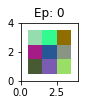

In [7]:
# som = SOM(x_size, y_size, num_features)
agri_som = SOM(3,3,3)

# Initial weights
init_fig = plt.figure()
agri_som.show_plot(init_fig, 1, 0)
plt.show()

Random weights (3 features) are given to each of 9 (3×3) neurons. The above figure shows how the neural network looks like in the beginning.

Notice: 

- after 60 Epochs, the network changed from random colors (initialization) to nearly constant color; this means that initial neighbourhood is large, so each neuron’s weight are being adjusted according to data.

- Slowly, the network develops different color according to input data structures/patterns, but, you can notice similar colors are neighbors to one another.

- Since there was a random initialization, the positions of colors may change but the topology will be preserved.

## Prediction and Analysis

In [8]:
def predict(df, agri_som):
    """
    finds the Best Matching Unit for each data sample.
    Thus, the neuron with closest distance from data sample.
    
    Args:
        df (pd.DataFrame): df to be updated
        agri_som (obj): model

    Returns:
        pd.DataFrame: updated df
    """
    bmu, bmu_idx = agri_som.find_bmu(df.values)
    df['bmu'] = bmu
    df['bmu_idx'] = bmu_idx
    return df


In [9]:
def arrange_data(agri_som):
    """
    Fetch BMU of data samples and append them to the filtered agri_dataset    

    Args:
        agri_som (object): SOM model

    Returns:
        pd.DataFrame: updated agri_data with BMU
    """
    clustered_df = trunc_data.apply(predict, axis=1, agri_som=agri_som)
    joined_df = agri_data.join(clustered_df, rsuffix="_norm")
    return joined_df

In [10]:
def external_purity(df):
    """Purity measures the purity of clusters with respect to ground-truth class labels. To compute the purity of a clustering Q, 
    each cluster is assigned to the class which is most frequent in the cluster, and then the accuracy of this assignment is measured 
    by counting the number of correctly assigned points and dividing by the total number of points:

    Args:
        df (pd.DataFrame): joined training set with bmu positions and weights
    """

    # proper representation of column
    df['bmu_idx'] = df['bmu_idx'].apply(lambda k: str(k))
    df['bmu'] = df['bmu'].apply(lambda k: k[0])

    # fetch number of different samples associated to each cluster.
    clusters = df.value_counts(subset=['Crop', 'bmu_idx']).reset_index() 
    clusters.rename(columns={0:'count'}, inplace=True)

    total = np.sum(clusters['count'])  # compute total number of points clustered

    # assign class which is most frequent in the cluster. highest count of that specific crop type in cluster
    cluster_dominated = clusters.groupby(by=['Crop']).max().reset_index()
    total_correct = np.sum(cluster_dominated['count'])  # compute total number of correctly clustered
    
    return total_correct/total
    

In [11]:
def visualize(joined_df, agri_som, function):
    fig = plt.figure()
    # setup axes
    ax = fig.add_subplot(111)
    scale = 50
    ax.set_xlim((0, agri_som.net.shape[0]*scale))
    ax.set_ylim((0, agri_som.net.shape[1]*scale))
    ax.set_title("Neighborhood radius: "+function)

    for x in range(0, agri_som.net.shape[0]):
        for y in range(0, agri_som.net.shape[1]):
            ax.add_patch(patches.Rectangle((x*scale, y*scale), scale, scale,
                         facecolor='white',
                         edgecolor='grey'))
    legend_map = {}

    for index, row in joined_df.iterrows():
        x_cor = row['bmu_idx'][0] * scale
        y_cor = row['bmu_idx'][1] * scale
        x_cor = np.random.randint(x_cor, x_cor + scale)
        y_cor = np.random.randint(y_cor, y_cor + scale)
        color = row['bmu'][0]
        marker = "$\\ " + row['Crop'][0]+"$"
        marker = marker.lower()
        ax.plot(x_cor, y_cor, color=color, marker=marker, markersize=10)
        label = row['Crop']
        if not label in legend_map:
            legend_map[label] =  mlines.Line2D([], [], color='black', marker=marker, linestyle='None',
                              markersize=10, label=label)
    plt.legend(handles=list(legend_map.values()), bbox_to_anchor=(1, 1))
    plt.show()
    return joined_df

In [12]:
# More rates, and decay functions can be appended. cost is running time
lrs = [1, 0.1, 0.01, 0.001]  # base learning rates
lfs = ["default"]#, "linear", "inverse", "power"]  # learning rate decay functions
rdfs = ["fixed"]#, "linear", "exponential"]  # radius decay functions.
epochs = [5,10,20,30,40,50]

# 32 runs/combinations in all
mesh = np.array(np.meshgrid(lrs, lfs, rdfs))
lrs_lfs_rdfs = mesh.T.reshape(-1, 3)

# agri_som = SOM(3,3,3)  # initialization
# weights = agri_som.net
weights = np.array(
	[
		[
			[0.04039447, 0.6495641 , 0.46165352],
			[0.9118578 , 0.28238622, 0.39812322],
			[0.58684143, 0.11878689, 0.99220547]
		],
       [
			[0.46852085, 0.94825253, 0.61640755],
			[0.80456765, 0.03104591, 0.45691878],
			[0.29590234, 0.77207143, 0.81684638]
		],
       [
			[0.96509498, 0.26071734, 0.78689664],
			[0.12195003, 0.47102914, 0.92465288],
			[0.81227374, 0.46423983, 0.98292867]
		]
	]
)

print(len(lrs_lfs_rdfs), 'runs')

4 runs


### **Euler Method**

In [13]:
# extract columns
lrs_ = [_[0] for _ in lrs_lfs_rdfs]
lfs_ = [_[1] for _ in lrs_lfs_rdfs]
rdfs_ = [_[2] for _ in lrs_lfs_rdfs]

data = {
    'learning_function': lfs_,
    'learning_rate': lrs_,
    'radius_function': rdfs_,
}
show_updates = False

# main runs
for epoch in epochs:
    print('working on epoch:', epoch)
    data.update({f'external.purity_{epoch}': []})  # updating dataframe

    for lr, lf, rdf in lrs_lfs_rdfs:
        lr = lr.astype('float64')

        agri_som = SOM(3,3,3)  # initialization
        agri_som.set_weights(weights.copy())

        agri_som.train(trunc_data.values,
            num_epochs=epoch,
            init_learning_rate=lr,
            lr_decay_function=lf,
            radius_decay_function=rdf,
            show_plot=False,
            method = 'euler'
            )
        joined_df = arrange_data(agri_som)
        # visualize(joined_df, lr, lf, agri_som)

        # combine external purity with computed mean-absolute-error
        ext_purity = round(external_purity(joined_df), 3)
        data[f'external.purity_{epoch}'].append(ext_purity)
        
        if show_updates:
            print(f'lr:{lr}, lrf:{lf}, rdf:{rdf} done!')


results_df = pd.DataFrame(data, index=range(1, len(lrs_lfs_rdfs)+1))
results_df.head()

working on epoch: 5
working on epoch: 10
working on epoch: 20
working on epoch: 30
working on epoch: 40
working on epoch: 50


,learning_function,learning_rate,radius_function,external.purity_5,external.purity_10,external.purity_20,external.purity_30,external.purity_40,external.purity_50
1,default,1.0,fixed,1.000,1.000,1.000,1.000,1.000,1.000
2,default,0.1,fixed,0.857,0.895,0.924,0.943,0.838,0.981
3,default,0.01,fixed,0.933,0.933,0.943,0.933,0.924,0.876
4,default,0.001,fixed,0.819,0.819,0.876,0.838,0.933,0.924


In [14]:
# results_df

### **Runge-Kutta Method**

In [15]:
"""
Implementation of Runge-Kutta method with the approximation function. (estimatesd MAE in brackets)

For smaller learning rates, estimated MAE improves and computed weights get closer to  approximated estimates.
higher accuracy purity for runge kutta second order method compared to the euler optimization method.
Accross epochs, the estimated error improves also with smaller learning rates.


"""

# extract columns
lrs_ = [_[0] for _ in lrs_lfs_rdfs]
lfs_ = [_[1] for _ in lrs_lfs_rdfs]
rdfs_ = [_[2] for _ in lrs_lfs_rdfs]

data = {
    'learning_function': lfs_,
    'learning_rate': lrs_,
    'radius_function': rdfs_,
}
show_updates = False

# main runs
for epoch in epochs:
    print('working on epoch:', epoch)
    data.update({f'external.purity_{epoch}': []})  # updating dataframe

    for lr, lf, rdf in lrs_lfs_rdfs:
        lr = lr.astype('float64')

        agri_som = SOM(3,3,3)  # initialization
        agri_som.set_weights(weights.copy())

        agri_som.train(trunc_data.values,
            num_epochs=epoch,
            init_learning_rate=lr,
            lr_decay_function=lf,
            radius_decay_function=rdf,
            show_plot=False,
            method = 'runge-kutta'
            )
        joined_df = arrange_data(agri_som)
        # visualize(joined_df, lr, lf, agri_som)

        # combine external purity with computed mean-absolute-error
        ext_purity = round(external_purity(joined_df), 3)

        data[f'external.purity_{epoch}'].append(ext_purity)
        
        if show_updates:
            print(f'lr:{lr}, lrf:{lf}, rdf:{rdf} done!')


results_df_rk = pd.DataFrame(data, index=range(1, len(lrs_lfs_rdfs)+1))
results_df_rk.head()

working on epoch: 5
working on epoch: 10
working on epoch: 20
working on epoch: 30
working on epoch: 40
working on epoch: 50


,learning_function,learning_rate,radius_function,external.purity_5,external.purity_10,external.purity_20,external.purity_30,external.purity_40,external.purity_50
1,default,1.0,fixed,1.000,1.000,1.000,0.905,1.000,1.000
2,default,0.1,fixed,0.781,0.886,0.810,0.943,0.762,0.876
3,default,0.01,fixed,0.895,0.924,0.895,0.905,0.914,0.905
4,default,0.001,fixed,0.724,0.810,0.800,0.810,0.886,0.914


In [16]:
results_df_rk

,learning_function,learning_rate,radius_function,external.purity_5,external.purity_10,external.purity_20,external.purity_30,external.purity_40,external.purity_50
1,default,1.0,fixed,1.000,1.000,1.000,0.905,1.000,1.000
2,default,0.1,fixed,0.781,0.886,0.810,0.943,0.762,0.876
3,default,0.01,fixed,0.895,0.924,0.895,0.905,0.914,0.905
4,default,0.001,fixed,0.724,0.810,0.800,0.810,0.886,0.914


### **Comments**

- we can observe the runge-kutta second order method generally performed better with higher accuracy values than the euler method.
- the estimated absolute error reduces significantly for smaller learning rates.